## DASH pipeline benchmarking

Let's obtain a Dask performance report for the most time-consuming dataset import (*object_forced_source*). 

The goal is to assess how long the I/O operations take in the **hats-import** pipeline:

1. Mapping: Read ra/dec
2. Splitting: Read every input parquet
3. Splitting: Write shards
4. Reducing: Read shards
5. Reducing: Write every output parquet

In [1]:
import tempfile
import hats_import.pipeline as runner

from dask.distributed import performance_report, Client
from dimension_reader import DimensionParquetReader
from hats_import.catalog.arguments import ImportArguments
from pathlib import Path

In [2]:
raw_dir = Path(f"/sdf/data/rubin/shared/lsdb_commissioning/raw/v29_0_0_rc5")
hats_dir = Path(f"/sdf/data/rubin/shared/lsdb_commissioning/sandro_test")

In [3]:
tmp_path = tempfile.TemporaryDirectory()
client = Client(n_workers=16, threads_per_worker=1, local_directory=tmp_path.name)

In [4]:
def get_paths(dataset_type):
    index_dir = raw_dir / "index" / dataset_type
    return list(index_dir.glob("*.csv"))

def get_common_import_args():
    return {
        "output_path": hats_dir,
        "simple_progress_bar": True,
        "resume": False,
        "delete_intermediate_parquet_files": False,
        "delete_resume_log_files": False,
    }

In [5]:
def profile_import(args):
    """Profiles performance for each Rubin data product"""
    catalog_name = args.output_artifact_name
    report_filepath = f"{catalog_name}.html"
    with performance_report(filename=report_filepath):
        runner.pipeline_with_client(args, client)
    # Gather statistics on the number of files
    get_num_input(catalog_name)
    get_num_shards(catalog_name)
    get_num_output(catalog_name)
    save_intermediate_filetree(catalog_name)

def get_num_input(catalog_name):
    # Number of input parquet files read for mapping is not 25, those are the grouped indexed ones
    index_dir = raw_dir / "index" / catalog_name
    num_input_files = !find {index_dir} -type f -name "*.csv" | xargs awk 'FNR > 1' | wc -l
    print(f"Num of input parquet files: {num_input_files}")

def get_num_shards(catalog_name):
    catalog_dir = hats_dir / catalog_name
    num_shards = !find {catalog_dir}/"intermediate" -type f | grep '/order_[^/]\+' | wc -l
    print(f"Num of generated shards: {num_shards}")

def get_num_output(catalog_name):
    catalog_dir = hats_dir / catalog_name
    num_output_files = !find {catalog_dir} -type f | grep '/Norder=[^/]\+' | wc -l 
    print(f"Num of output parquet: {num_output_files}")

def save_intermediate_filetree(catalog_name):
    intermediate_dir = hats_dir / catalog_name / "intermediate"
    !tree {intermediate_dir} > {catalog_name}.txt

#### dia_object

In [6]:
dia_obj_default_columns = ["diaObjectId", "ra", "dec", "nDiaSources", "radecMjdTai"]

args = ImportArguments(
    output_artifact_name="dia_object",
    input_file_list=get_paths("dia_object"),
    file_reader=DimensionParquetReader(column_names=dia_obj_default_columns),
    ra_column="ra",
    dec_column="dec",
    catalog_type="object",
    highest_healpix_order=0,
    pixel_threshold=5_000_000,
    **get_common_import_args()
)
profile_import(args)

Finishing : 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 59.97it/s]


Num of input parquet files: ['25']
Num of generated shards: ['26']
Num of output parquet: ['4']


#### dia_source

In [7]:
args = ImportArguments(
    output_artifact_name="dia_source",
    input_file_list=get_paths("dia_source"),
    file_reader=DimensionParquetReader(),
    ra_column="ra",
    dec_column="dec",
    catalog_type="source",
    highest_healpix_order=0,
    pixel_threshold=4_000_000,
    **get_common_import_args()
)
profile_import(args)

Finishing : 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.36it/s]


Num of input parquet files: ['25']
Num of generated shards: ['27']
Num of output parquet: ['4']


#### dia_object_forced_source

In [8]:
args = ImportArguments(
    output_artifact_name="dia_object_forced_source",
    input_file_list=get_paths("dia_object_forced_source"),
    file_reader=DimensionParquetReader(),
    ra_column="coord_ra",
    dec_column="coord_dec",
    catalog_type="source",
    pixel_threshold=25_000_000,
    highest_healpix_order=9,
    **get_common_import_args()
)
profile_import(args)

Finishing : 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.43it/s]


Num of input parquet files: ['596']
Num of generated shards: ['1006']
Num of output parquet: ['28']


#### object

In [9]:
cols_per_band = []
for band in list("ugrizy"):
    for flux_type in ["psf", "kron"]:
        prefix = f"{band}_{flux_type}"
        cols_per_band.extend([f"{prefix}Flux", f"{prefix}FluxErr"])
    cols_per_band.append(f"{band}_kronRad")

obj_default_columns = [
    "objectId",
    "refFwhm",
    "shape_flag",
    "sky_object",
    "parentObjectId",
    "x",
    "y",
    "xErr",
    "yErr",
    "shape_yy",
    "shape_xx",
    "shape_xy",
    "coord_ra",
    "coord_dec",
    "coord_raErr",
    "coord_decErr",
    "tract",
    "patch",
    "detect_isIsolated",
] + cols_per_band

args = ImportArguments(
    output_artifact_name="object",
    input_file_list=get_paths("object"),
    file_reader=DimensionParquetReader(
        column_names=obj_default_columns, chunksize=250_000
    ),
    ra_column="coord_ra",
    dec_column="coord_dec",
    catalog_type="object",
    highest_healpix_order=7,
    pixel_threshold=300_000,
    **get_common_import_args()
)
profile_import(args)

Finishing : 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.98it/s]


Num of input parquet files: ['29']
Num of generated shards: ['56']
Num of output parquet: ['21']


#### source

In [10]:
args = ImportArguments(
    output_artifact_name="source",
    input_file_list=get_paths("source"),
    file_reader=DimensionParquetReader(),
    ra_column="ra",
    dec_column="dec",
    catalog_type="source",
    highest_healpix_order=9,
    pixel_threshold=1_000_000,
    **get_common_import_args()
)
profile_import(args)

Finishing : 100%|█████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Num of input parquet files: ['1786']
Num of generated shards: ['4846']
Num of output parquet: ['127']


#### object_forced_source

In [11]:
args = ImportArguments(
    output_artifact_name="object_forced_source",
    input_file_list=get_paths("object_forced_source"),
    file_reader=DimensionParquetReader(),
    ra_column="coord_ra",
    dec_column="coord_dec",
    catalog_type="source",
    highest_healpix_order=9,
    pixel_threshold=25_000_000,
    **get_common_import_args()
)
profile_import(args)

Finishing : 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


Num of input parquet files: ['635']
Num of generated shards: ['1469']
Num of output parquet: ['34']


### Read vs write on each stage

To help with visualization of these benchmarks I extracted the following timings from each Dask report. These do not represent duration, but total "compute time".

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
stages = ["Mapping+Binning", "Splitting", "Reducing"]

read_times = {
    "dia_object": [1.13, 0.4, 0.05],
    "dia_source": [0.79, 2.24, 1.27],
    "dia_object_forced_source": [17.28, 32.23, 21.42],
    "object": [1.3, 1.32, 0.8],
    "source": [15.61, 60.72, 49.87],
    "object_forced_source": [25.26, 45.36, 31.92]
}
write_times = {
    "dia_object": [0.5, 0.44, 0.22],
    "dia_source": [0.04, 7.83, 5.63],
    "dia_object_forced_source": [0.05, 103.36, 78.86],
    "object": [0.22, 5.51, 5.74],
    "source": [0.25, 278.36, 187.02],
    "object_forced_source": [0.18, 142.89, 109.97]
}

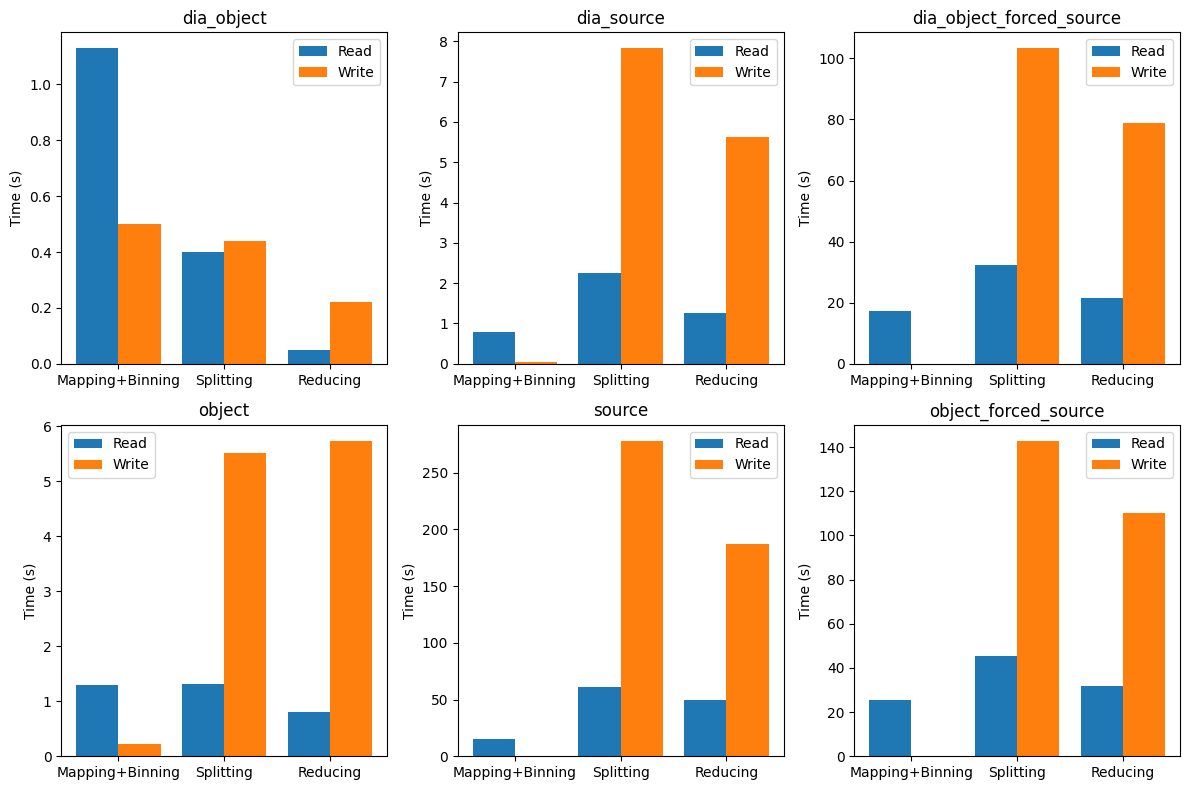

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
x = np.arange(3)

for i, key in enumerate(read_times.keys()):
    axes[i].bar(x - 0.2, read_times[key], width=0.4, label='Read')
    axes[i].bar(x + 0.2, write_times[key], width=0.4, label='Write')
    axes[i].set_title(key)
    axes[i].set_ylabel('Time (s)')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([stages[j] for j in range(3)])
    axes[i].legend()

plt.tight_layout()
plt.show()

### Cleanup

In [12]:
client.close()
tmp_path.cleanup()